### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

Done


### Get data

In [2]:
datadir = pathlib.Path("/home/jcc319/data/random_walk")
_AllAnimalList = ['Chewie', 'Mihili', "MrT"]

_AllAnimalFiles=[]
for animal in _AllAnimalList:
    _AllAnimalFiles.extend(utility.find_file(datadir / animal, 'mat'))

In [3]:
raw_df = pyal.mat2dataframe(_AllAnimalFiles[0], shift_idx_fields=True)
raw_df.head()


,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,perturbation_info,epoch,idx_trial_start,idx_go_cue,idx_trial_end,pos,vel,acc,force,M1_spikes,M1_unit_guide
0,Chewie,12-13-2013,RT,"[[6.837241172790527, 8.959444046020508], [-1.1...",1,R,0.01,VR,0.52,BL,9,"[19, 102, 202, 275]",355,"[[5.442727287317725, -34.53324075887817], [5.4...","[[0.5936249226750506, 2.3695806261322594], [0....","[[-45.55166384606839, 3.155726126529143], [-40...","[[-0.419910379339606, -0.20573448234655436], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1..."
1,Chewie,12-13-2013,RT,"[[-1.099478840827942, 4.949634552001953], [3.2...",2,R,0.01,VR,0.52,BL,9,"[19, 94, 193, 279]",329,"[[7.150144087244177, -30.07332136452093], [7.1...","[[-2.1868142899825243, -6.277170989189995], [-...","[[-19.056730327350383, 2.317259234457083], [-2...","[[-0.240245946959191, -0.5210908728563152], [-...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1..."
2,Chewie,12-13-2013,RT,"[[2.4766507148742676, 3.414874315261841], [7.3...",3,R,0.01,VR,0.52,BL,9,"[19, 105, 190, 285]",345,"[[10.62163852196618, -27.132327682368725], [10...","[[-2.0678070329226634, -11.473831692165849], [...","[[-28.73019529611891, -6.314640473534496], [-4...","[[-0.2036002095909978, -0.6750728584776086], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1..."
3,Chewie,12-13-2013,RT,"[[0.0, 0.04888395592570305], [0.0, 4.018441200...",5,R,0.01,VR,0.52,BL,9,"[19, 95, 174, 248]",309,"[[-2.9030662764410575, -35.96134310799778], [-...","[[3.9853114746731992, 6.335575658141003], [4.2...","[[31.62734996546982, -32.1547799005031], [22.3...","[[-0.5048118881513025, -0.1718568604114036], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1..."
4,Chewie,12-13-2013,RT,"[[3.652657985687256, 1.049389362335205], [-6.7...",7,R,0.01,VR,0.52,BL,9,"[19, 116, 182, 247]",295,"[[2.9404847628016206, -32.38023284736009], [2....","[[-1.4271695596564575, 0.6422790996897157], [-...","[[-44.925787834115035, -26.214239352377636], [...","[[-0.3546302390789349, -0.023329020534123612],...","[[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1..."


In [4]:
df = pyal.select_trials(raw_df, "result == 'R'")
df = pyal.select_trials(df, "epoch == 'BL'")
df = pyal.restrict_to_interval(df, start_point_name = 'idx_trial_start', end_point_name = 'idx_trial_end')

#center pos
mean_pos = np.mean(np.vstack(df.pos), axis = 0)
df['pos'] = [x - mean_pos for x in df['pos']] 
df['target_center'] = [np.reshape(x.T.flatten(), x.shape, order = 'C') for x in df['target_center']]
df[['idx_go_cue1',
    'idx_go_cue2',
    'idx_go_cue3',
    'idx_go_cue4']] = pd.DataFrame(df.idx_go_cue.tolist(), index= df.index)
# df.head()


### separate into reaches

In [8]:
df_reaches = pd.DataFrame()
for i in range(4):
    start_point_name = 'idx_go_cue' +str(i+1)
    end_point_name = ('idx_go_cue' + str(i+2)) if i < 3 else 'idx_trial_end'
    df_ = pyal.restrict_to_interval(df, start_point_name, end_point_name)
    df_['target_center'] = [x[i] for x in df_['target_center']]
    df_['reach'] = i+1
    df_['idx_go_cue']= df_[start_point_name]
    df_['idx_reach_end'] = df_[end_point_name] - df_[start_point_name] 
    df_reaches = pd.concat([df_reaches, df_])
df_reaches = df_reaches.sort_values(by=['trial_id', 'reach'])
df_reaches = df_reaches[df_reaches.idx_reach_end < 200] #TODO: better cutoff for slow reaches
df_reaches['dist_start_center'] = [np.linalg.norm(x[0]) for x in df_reaches.pos]
df_reaches.head()

,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,force,M1_spikes,M1_unit_guide,idx_go_cue1,idx_go_cue2,idx_go_cue3,idx_go_cue4,reach,idx_reach_end,dist_start_center
0,Chewie,12-13-2013,RT,"[6.837241172790527, -1.1846615076065063]",1,R,0.01,VR,0.52,BL,...,"[[-0.29147858958677375, -0.5169287956651768], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1...",0.0,83.0,NaN,NaN,1,83,2.153356
0,Chewie,12-13-2013,RT,"[2.118772506713867, 0.46944040060043335]",1,R,0.01,VR,0.52,BL,...,"[[0.2064816994600353, 0.3054729004219485], [0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1...",NaN,0.0,100.0,NaN,2,100,6.832217
0,Chewie,12-13-2013,RT,"[8.959444046020508, -3.5283751487731934]",1,R,0.01,VR,0.52,BL,...,"[[-0.3869071035460753, 0.060273326782476905], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1...",NaN,NaN,0.0,73.0,3,73,2.318706
0,Chewie,12-13-2013,RT,"[4.83456563949585, 3.048969030380249]",1,R,0.01,VR,0.52,BL,...,"[[0.00984046275317605, 0.1228568030122672], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1...",NaN,NaN,NaN,0.0,4,80,9.078998
1,Chewie,12-13-2013,RT,"[-1.099478840827942, 3.26007080078125]",2,R,0.01,VR,0.52,BL,...,"[[-0.3719451058100934, -0.5506157395734467], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1...",0.0,75.0,NaN,NaN,1,75,3.954502


### look at reaches

(-10.0, 10.0)

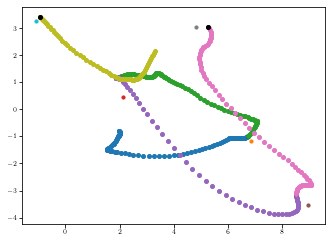

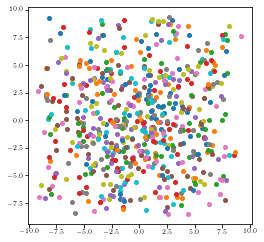

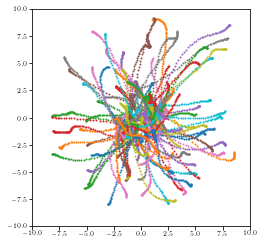

In [15]:
# sequential reaches
ntrials = 5
plt.figure()
for pos,targets in zip(df_reaches.pos[:ntrials], df_reaches.target_center[:ntrials]):
    plt.scatter(*pos[:].T)
    plt.scatter(*pos[-1].T, c = 'k')
    plt.scatter(*targets[:].T, s = 10)

plt.gca().set_aspect(1)

#all starting locations
plt.figure()
for pos,targets in zip(df_reaches.pos[:], df_reaches.target_center[:]):
    plt.scatter(*pos[0].T)
    # plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

#subset reaches that start around the center
plt.figure()
df_ = df_reaches[df_reaches.dist_start_center <2.5]
for pos,targets in zip(df_.pos[:], df_.target_center[:]):
    plt.scatter(*pos[:].T,s=1)
    # plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])


In [11]:
pathPickle = root / 'monkey-pickles' / f'{df1__.session[0]}_{df2__.session[0]}_across_corr.p'
if os.path.exists(pathPickle) and not redo:
    with open(pathPickle,"rb") as f:
        result=pickle.load(f)
    across_corrs[df1__.session[0]][df2_

94

(array([  4.,  11., 139., 280., 125.,  44.,   6.,   2.,   3.,   1.]),
 array([ 20. ,  35.5,  51. ,  66.5,  82. ,  97.5, 113. , 128.5, 144. ,
        159.5, 175. ]),
 <BarContainer object of 10 artists>)

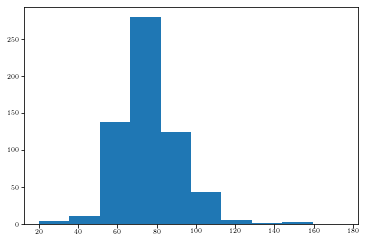

In [168]:
plt.hist(df_.idx_reach_end)